In [116]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import sys
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import random
import pylab
from scipy import interpolate

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Preprocessing des données (moyenne nulle, variance 1)

In [2]:
def processing(time_series):
    return (time_series-np.mean(time_series))/np.std(time_series)

## Définition de la métrique d'erreur

In [8]:
def metric(t_s1, t_s2):
    return np.square( np.tile(t_s1,(t_s1.shape[0],1))-np.tile(t_s2,(t_s2.shape[0],1)).transpose())

## Définition du poids de Boltzmann

In [10]:
def Boltzmann(t_s1,t_s2,T=1.2):
    return np.exp(-metric(t_s1,t_s2)/T)

# Changement de coordonnées

### Linear indexing 

### Rotated indexing 

# DP on a lattice Alberto 

In [50]:
random.seed(-2)
# T should be odd
T=101
beta=1

### Free energy and position of the point to point DP at zero temperature

In [117]:
lattice = np.zeros((T,2*T-1))
E = 10000*np.ones(2*T-1)

## Definition of the starting point
E[0]=0

for time in range(1,T) :
    for x in range(time,-time-2,-2) :
        values=[E[x-1],E[x+1]]
        lattice[time,x]=2*np.argmin(values)-1
        E[x]=np.amin(values)+np.random.normal()

### Plot of the energy and the position of the point to point DP at zero temperature

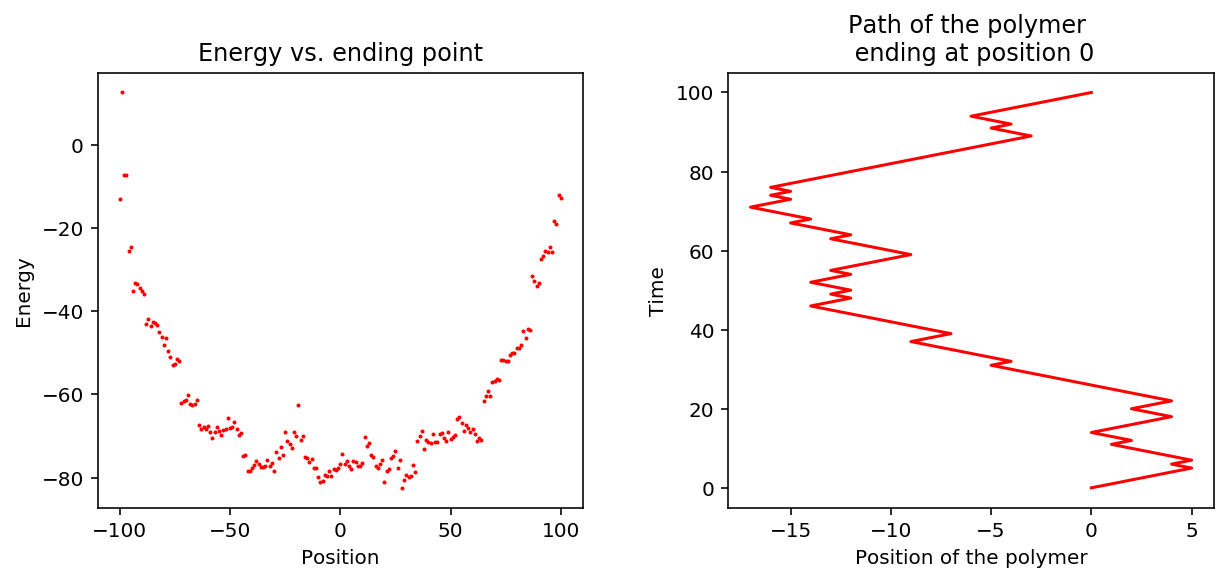

In [118]:
### Energy of the polymer

xt1 = np.arange(T)
xt2 = np.arange(T-1)-T+1
xt = np.concatenate((xt1,xt2))

### Path of the polymer
## Definition of the ending point
itoto=0

Polym=np.zeros(T)
Polym[T-1]=itoto

for time in range(1,T-1):
    idelta=lattice[T-time,int(itoto)]
    itoto+=idelta
    Polym[T-1-time]=itoto
    
plt.figure(6,figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xt,E, 'r.', markersize=2)
plt.title('Energy vs. ending point')
plt.xlabel('Position'), plt.ylabel('Energy')

plt.subplot(1, 2, 2)
plt.plot(Polym,range(T), 'r', markersize=2)
plt.title('Path of the polymer \n ending at position '+str(int(Polym[T-1])))
plt.xlabel('Position of the polymer'), plt.ylabel('Time')
plt.subplots_adjust(wspace=0.3)
plt.show(block=False)

### Calculation of the partition function at temperature beta

In [119]:
Z=np.zeros(2*T-1)

## Definition of the starting point
Z[0]=1

for time in range(1,T) :
    for x in range(time,-time-2,-2) :
        Z[x]=(Z[x-1]+Z[x+1])*np.exp(-beta*np.random.normal())
        
#        values=[E[x-1],E[x+1]]
#        lattice[time,x]=2*np.argmin(values)-1
#        E[x]=np.amin(values)+np.random.normal()

### Calculation of the position of the DP at temperature beta 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

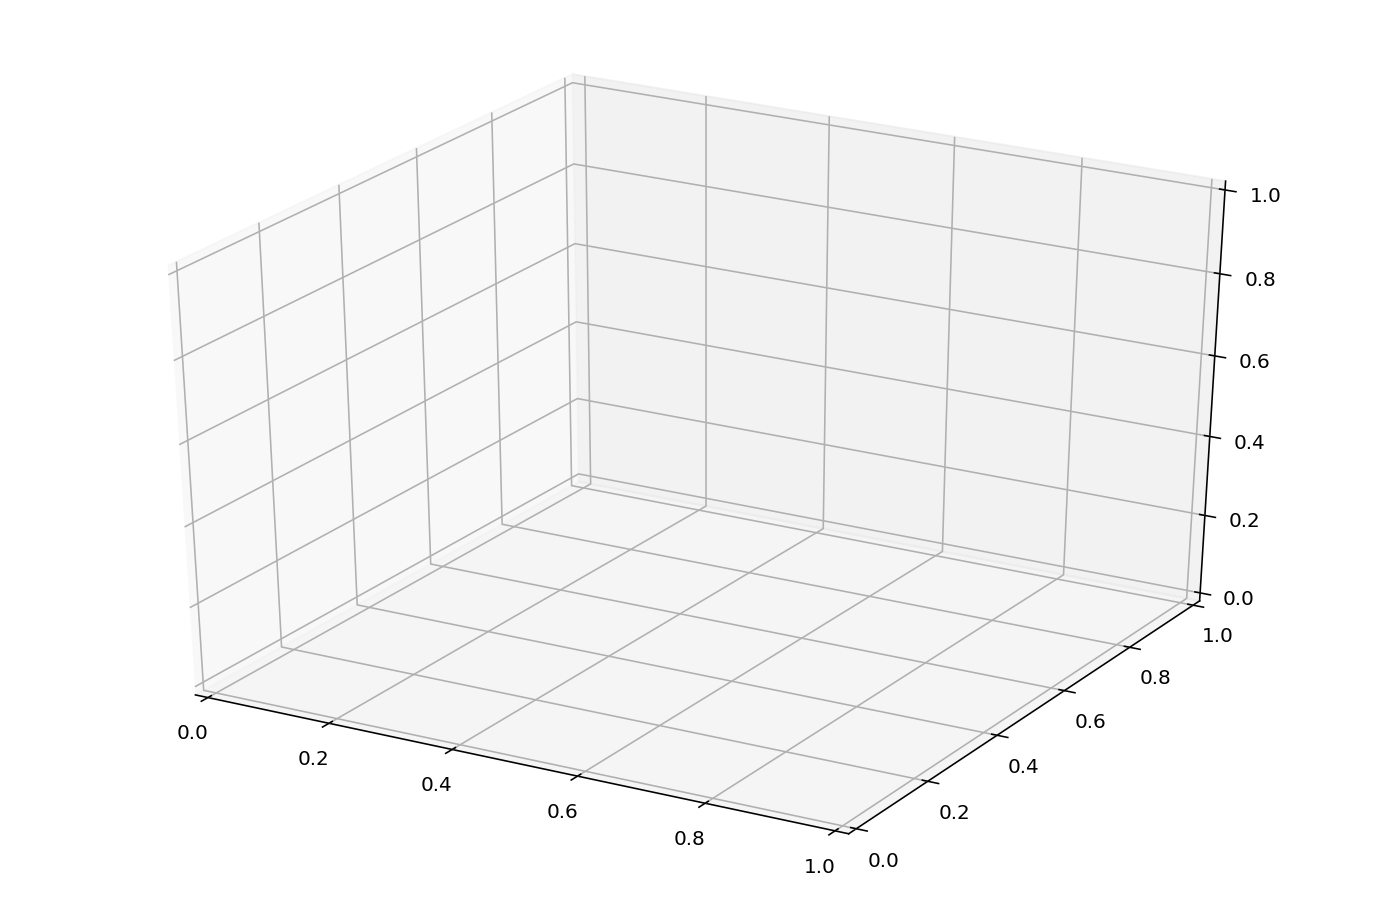

In [120]:
def zero_temperature_position_3D_2(T=101) :
    # T should be odd
    lattice=np.zeros((T,2*T-1))
    E=10000*np.ones(2*T-1)

    disorder=np.random.normal(size=(T,2*T-1))

    disorder2=np.roll(disorder, T, axis=1)

    fig = plt.figure(6,figsize=(12, 8))
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(-T, T)
    Y = np.arange(0, T)
    X, Y = np.meshgrid(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, disorder2, cmap=cm.jet,linewidth=1, antialiased=True)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('time')
    ax.set_zlabel('Disorder strength')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show(block=False)

    #### Smoothing the surface

    xnew, ynew = np.mgrid[-T:T:0.5, -T:T:0.5]
    tck = interpolate.bisplrep(X, Y, disorder2, s=0)
    znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

    fig2 = plt.figure(7,figsize=(12,8))
    ax2 = fig2.gca(projection='3d')
    surf2=ax2.plot_surface(xnew, ynew, znew, cmap=cm.jet, rstride=1, cstride=1, alpha=None, antialiased=True)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax2.set_xlabel('x')
    ax2.set_ylabel('time')
    ax2.set_zlabel('Disorder strength')

    fig.colorbar(surf2, shrink=0.5, aspect=5)
    plt.show(block=False)
    
zero_temperature_position_3D_2()

# DP on a lattice Alberto 2

In [ ]:
T  = 80
beta=1
Z=[0 for n in range(-T,T-1)]
Z[0]=1
xfree=0
for time in range(1,T) :
    xmax=-1
    for n in range(time+1):
        x=time-2*n
        Z[x]=(Z[x-1]+Z[x+1])*math.exp(-beta*random.gauss(0,1))
        if xmax <Z[x]:
            xmax=Z[x]
    xfree+=math.log(xmax)
    Z[:] = [x/xmax for x in Z]   
F = [-xfree - math.log(Z[n])  for n in range(-T,T-1)]     
pylab.plot(F, 'r.', markersize=2)
pylab.show()

# DP on a lattice moi

In [ ]:
# Transfer matrix method at non-zero temperature
## In time frame t1,t2
### FORWARD
memo2={}
def partition_forward(t1,t2,epsilon,T,N,t10,t20,t11,t21):
    if (t1<t10 or t2<t20 or t1>t11 or t2>t21):
        return 0
    else:
        if not (t1,t2) in memo2:
            if (t1==0 and t2==0):
                memo2[t1,t2]=epsilon[t1,t2]
            else:
                memo2[t1,t2]=epsilon[t1,t2] * (partition_forward(t1,t2-1,epsilon,T,N) + partition_forward(t1-1,t2,epsilon,T,N) + partition_forward(t1-1,t2-1,epsilon,T,N))
        return memo2[t1,t2]

### BACKWARD
memo3={}
def partition_backward(t1,t2,epsilon,T,N, t10, t20, t11,t21):
    if (t1>t11 or t2>t21 or t1<t10 or t2<t20):
        return 0
    else:
        if not (t1,t2) in memo3:
            if (t1==N-1 and t2==N-1):
                memo3[t1,t2]=epsilon[t1,t2]
            else:
                memo3[t1,t2]=epsilon[t1,t2] * (partition_backward(t1,t2+1,epsilon,T,N)+partition_backward(t1+1,t2,epsilon,T,N)+partition_backward(t1+1,t2+1,epsilon,T,N))
        return memo3[t1,t2]

## In rotated frame where t=t1+t2 and x=t2-t1
## Partition function
def sum_partition_rotated(partition,t,epsilon,T,N,t10,t20,t11,t21):
    sum=0
    if (t=>t10+t20 and t<=t11+t21):
        for x in range(int(np.maximum(-t,t-2*(N-1))),int(np.minimum(t,2*(N-1)-t))+1):
            if ((t-x)%2==0 and (t+x)%2==0):
                sum+=partition((t-x)/2,(t+x)/2,epsilon,T,N,t10,t20,t11,t21)
    return sum

## Average of lead/lag <x(t)>
def average_x(partition,t,epsilon,T,N,t10,t20,t11,t21):
    avr_x=0
    if (t=>t10+t20 and t<=t11+t21):
        for x in range(int(np.maximum(-t,t-2*(N-1))),int(np.minimum(t,2*(N-1)-t))+1):
            if ((t-x)%2==0 and (t+x)%2==0):
                avr_x+=x*partition((t-x)/2,(t+x)/2,epsilon,T,N,t10,t20,t11,t21)
    return avr_x/sum_partition_rotated(partition,t,epsilon,T,N,t10,t20,t11,t21)

## Cost energy
def cost_energy(partition,t,epsilon,T,N,t10,t20,t11,t21):
    cost_energy=0
    if (t=>t10+t20 and t<=t11+t21):
        for x in range(int(np.maximum(-t,t-2*(N-1))),int(np.minimum(t,2*(N-1)-t))+1):
            if ((t-x)%2==0 and (t+x)%2==0):
                cost_energy+=epsilon[(t-x)/2,(t+x)/2]*partition((t-x)/2,(t+x)/2,epsilon,T,N,t10,t20,t11,t21)
    return cost_energy/sum_partition_rotated(partition,t,epsilon,T,N,t10,t20,t11,t21)

# TOPS METHOD

In [7]:
def tops_average_x(t,epsilon,T,N,t10,t20,t11,t21):
    return ( average_x(partition_forward,t,epsilon,T,N,t10,t20,t11,t21) + average_x(partition_backward,t,epsilon,T,N,t10,t20,t11,t21) )/2.

def tops_cost_energy(epsilon,T,N,t10,t20,t11,t21):
    tops_cost=0
    for t in range(t10+t20,t11+t21):
        tops_cost+=(cost_energy(partition_forward,t,epsilon,T,N)+cost_energy(partition_backward,t,epsilon,T,N))/2.
    return tops_cost/(2*N-1)

# Data vizualization

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(t_s1), ax1.plot(t_s2)

TOPS=ax2.plot(np.arange(2*nb_points-1)/2., average_tops, label='TOPS')
model=ax2.plot(np.arange(nb_points), theoretical, label='Model')
ax2.legend(['TOPS','Model'])

plt.show(block=False)
raw_input("<Hit Enter To Close>")
plt.close()


memo2plot=[sum_partition_rotated(partition_forward,t,epsilon_minus,T,nb_points) for t in range(2*nb_points-1)]
memo3plot=[sum_partition_rotated(partition_backward,t,epsilon_minus,T,nb_points) for t in range(2*nb_points-1)]

plt.plot(memo2plot)
plt.plot(memo3plot)
plt.legend(['memo2','memo3'])
plt.show(block=False)
raw_input("<Hit Enter To Close>")
plt.close()

memo44=np.array([np.log10(memo2[i,i]) for i in range(nb_points)])

plt.plot(memo44)
plt.legend(['forward partition function diagonal'])
plt.show(block=False)